# Training a custom Text Summarization Model

- Dependencies to be installed

In [ ]:
# !pip install GPUtil
# !pip install transformers
# !pip install git-lfs
# !pip unstall sentencepiece

- GPUtil is a Python module for getting the GPU status from NVIDA GPUs using nvidia-smi.

In [10]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()     

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 31% | 11% |


In [11]:
import torch
print(torch.__version__)

1.11.0


In [12]:
torch.cuda.is_available()
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

11.3
NVIDIA GeForce GTX 1060 with Max-Q Design


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the dataset
- We'll be using the SAMSum dataset (developed by Samsung), which consists of a collection of dialogues along with brief summaries.

In [15]:
from datasets import load_dataset
samsum = load_dataset('samsum')

Reusing dataset samsum (/home/anegi/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [17]:
print(f"Features : {samsum['train'].column_names}")

Features : ['id', 'dialogue', 'summary']


- Let's us check the dialogue and its summary given in the SAMSUM dataset

In [18]:
print("Dialogue: \n")
print(samsum['train'][5]['dialogue'])

Dialogue: 

Neville: Hi there, does anyone remember what date I got married on?
Don: Are you serious?
Neville: Dead serious. We're on vacation, and Tina's mad at me about something. I have a strange suspicion that this might have something to do with our wedding anniversary, but I have nowhere to check.
Wyatt: Hang on, I'll ask my wife.
Don: Haha, someone's in a lot of trouble :D
Wyatt: September 17. I hope you remember the year ;)


In [5]:
print("Summary: \n")
print(samsum['train'][5]['summary'])

Summary: 

Wyatt reminds Neville his wedding anniversary is on the 17th of September. Neville's wife is upset and it might be because Neville forgot about their anniversary.


# T5 (Text to Text Transfer Transformer) Model
## Key points
- Treats each NLP problem as a “text-to text” problem and reaches SOTA results- input:text, output:text
- Unified approach for NLP Deep Learning- Since the task is purely reflected in the text input and output, we can use the same model for summarization, Q&A etc.
- Multiple NLP tasks can live in the same model.


In [10]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

### Checking the length distribution of dialogue and summary
- tokenizer.encode - Converts a string to a sequence of ids (integer), using the tokenizer and vocabulary.

In [11]:
d_len = [len(tokenizer.encode(text)) for text in samsum['train']['dialogue']]
s_len = [len(tokenizer.encode(text)) for text in samsum['train']['summary']]

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


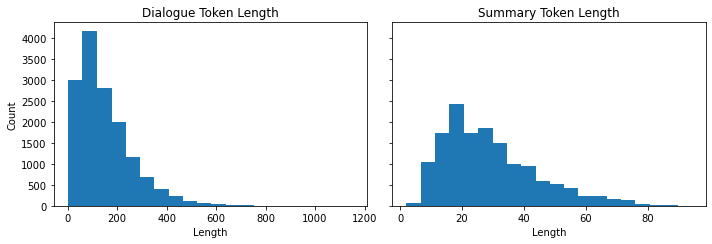

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()


- Most of our dialogue lengths are between 100-200 tokens per dialogue and summary lenth is between 20-40 tokens per dialogue.

In [ ]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()             

# ------------------------------------------------------------------------------------------

### Let us tokenize the dataset
- We’ll set the maximum lengths to 1024 for the dialogues and 128 for the summaries.
- Using the with statements, the tokenizer knows that it is tokenizing for the decoder and acts accordingly.

In [ ]:
def convert_examples_to_features(example_batch):
    
    input_encodings = tokenizer(example_batch["dialogue"],
                                max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"],
                                     max_length=128,
                                     truncation=True)
        
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}


In [ ]:
dataset_samsum_pt = samsum.map(convert_examples_to_features, 
                               batched=True)

columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)


### Create Data Collator
- Data collators put together a list of samples into a single training mini batch.
- Both inputs and labels must be padded for these kind of models 

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

### Logging into HuggingFace so that we can push our model to the Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

### Setting up TrainingArguments for training

- You can fine tune your transformer model on your data set

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                                  't5-small-demo1',
                                  num_train_epochs=1, 
                                  warmup_steps=500,
                                  per_device_train_batch_size=1, 
                                  per_device_eval_batch_size=1,
                                  weight_decay=0.01,
                                  logging_steps=10, 
                                  push_to_hub=True,
                                  push_to_hub_model_id='t5-small-demo1',  
                                  evaluation_strategy='steps',
                                  eval_steps=500,
                                  save_steps=1e6,
                                  gradient_accumulation_steps=16
                                 )

In [ ]:
trainer = Trainer(model = model, 
                  args = training_args,
                  tokenizer = tokenizer,
                  data_collator = seq2seq_data_collator,
                  train_dataset = dataset_samsum_pt["train"],
                  eval_dataset = dataset_samsum_pt["validation"]
                 )

In [ ]:
trainer.train()

- Pusing our model to the hub so that we can easily use it

In [ ]:
trainer.push_to_hub("Trainer push")
tokenizer.push_to_hub('Tokenizer push')
model.push_to_hub('Model push')

# -------------------------------------------------------------------------------------------

## Testing our model on random conversation

In [19]:
conversation = '''
Aakash: Did you watched last night match?
Vikas: No, I was busy. What happended?
Aakash: Barcelona won their game against Sevilla 1-0. Pedri scored an sensational goal.
Vikas: Oh really!!! I have to watch the highlights at home.
Aakash: Yes, I am so excited for the new upcoming season. Xavi really doing wonders.
Vikas: Exactly!! Xavi has changed the way Barcelona play. The good days are coming back. 
'''

In [2]:
from transformers import pipeline

In [3]:
summarizer = pipeline('summarization', model = 'anegi/t5smallmodel')

In [4]:
summary_generated = summarizer(conversation, max_length=90, min_length = 35)

In [5]:
summary_generated

[{'summary_text': 'Pedri scored a sensational goal for Barcelona against Sevilla . Xavi has changed the way they play. Aakash is excited for the new season.'}]

# -----------------------------------------------------------------------------------------

## ROUGE metric
- On our trained model(t5-small)

In [20]:
from rouge_score import rouge_scorer

In [22]:
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'],
                                  use_stemmer=True)

# Adding a summary that a human would generate when the above conversation is provided to them.

scores = scorer.score('Pedri scored a sensational goal for Barcelona against Sevilla . Xavi has changed the way they play. Aakash is excited for the new season.',
                      '''Vikas asked Aakash about the match where Barcelona played against Sevilla and won.
                         Pedri scored the only goal. Both are excited fot the upcoming season.''')

- Converting the scores to dataframe

In [23]:
df_score = pd.DataFrame(scores)

In [24]:
df_score.index = ['precision','recall','fmeasure']

In [25]:
df_score

,rouge1,rouge2,rougeL
precision,0.480000,0.083333,0.280000
recall,0.521739,0.090909,0.304348
fmeasure,0.500000,0.086957,0.291667


- On a pre trained model(bart-largecnn-samsum)

In [26]:
summarizer2 = pipeline('summarization', model="philschmid/bart-large-cnn-samsum") 

In [27]:
summary_generated2 = summarizer2(conversation, max_length=90, min_length = 35)

In [28]:
summary_generated2

[{'summary_text': 'Barcelona won their game against Sevilla 1-0. Pedri scored the only goal. Vikas has to watch the highlights at home. Aakash is excited about the upcoming season.'}]

In [29]:
scores2 = scorer.score('Barcelona won their game against Sevilla 1-0. Pedri scored the only goal. Vikas has to watch the highlights at home. Aakash is excited about the upcoming season.',
                      '''Vikas asked Aakash about the match where Barcelona played against Sevilla and won.
                         Pedri scored the only goal. Both are excited fot the upcoming season.''')

In [30]:
df_score2 = pd.DataFrame(scores2)

In [31]:
df_score2.index = ['precision','recall','fmeasure']

In [32]:
df_score2

,rouge1,rouge2,rougeL
precision,0.680000,0.333333,0.480000
recall,0.607143,0.296296,0.428571
fmeasure,0.641509,0.313725,0.452830


# -----------------------------------------------------------------------------------------

#### Method 2

- The ROUGE metric in the HuggingFace Datasets library also calculates confidence intervals
  ( by default, the 5th and 95th percentiles). The average value is stored in the attribute mid and
   the interval can be retrieved with low and high.

In [ ]:
from datasets import load_metric
rougue_metric = load_metric('rouge')

In [ ]:
rougue_metric.add(prediction = 'Pedri scored a sensational goal for Barcelona against Sevilla . Xavi has changed the way they play. Aakash is excited for the new season.',
                  reference =  '''Vikas asked Aakash about the match where Barcelona played against Sevilla and won.
                         Pedri scored the only goal. Both are excited fot the upcoming season.''')

In [ ]:
score3 = rougue_metric.compute()

- Converting the scores into dataframe

In [ ]:
df = pd.DataFrame.from_dict(score3, orient="index").stack().to_frame()

# to break out the lists into columns

df_score3 = pd.DataFrame(df[0].values.tolist(), index=df.index)

In [ ]:
df_score3

# -------------------------------------------------------------------------------------------------------------